# Определение перспективного тарифа для телеком компании

Заказчик - компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. 

### Навигация

1. [Открытие файла с данными и изучение общей информации](#start)
2. [Предобработка данных](#preprocessing)
3. [Исследовательский анализ данных](#discover)
4. [Проверка статистических гипотез](#stat)
5. [Общий вывод.](#Conclusion)


### Шаг 1. <a id="start"></a>Открытие файла с данными и изучение общей информации

In [48]:
import pandas as pd
import numpy as np
from scipy import stats as st

pd.options.display.float_format='{:.2f}'.format
pd.options.mode.chained_assignment = None

In [49]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')


calls.info()
print()
internet.info()
print()
messages.info()
print()
tariffs.info()
print()
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB

<class 'pandas.core.frame.DataFrame'>
R

### Вывод 

Открыв файлы: /datasets/calls.csv, /datasets/internet.csv, /datasets/messages.csv, /datasets/tariffs.csv, /datasets/users.csv - была получена следующая информация:
##### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

##### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

##### Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

##### Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

##### Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 2. <a id="preprocessing"></a> Предобработка данных

In [50]:
users_final = users[['user_id', 'city', 'tariff']]
users_final.columns = ['user_id', 'city', 'tariff_name']

users_final.head(20)

,user_id,city,tariff_name
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra
5,1005,Набережные Челны,smart
6,1006,Ульяновск,smart
7,1007,Москва,smart
8,1008,Челябинск,smart
9,1009,Пермь,smart


In [51]:
calls # звонков много по каждому id, нужно такие звонки сгруппировать по идентификатору и посчитать общее время разговоров
calls.duplicated().sum() # полные дубликаты отсутствуют
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

calls_good = (calls
              .query('duration != 0.0') 
              # исключим из нашего объема данных звонки в 00:00 минут, поскольку это 
              # не влияет на объем потребленного числа звонков и скорее всего свзязано с фиксацией не дозвонившихся звонков
             
              .pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])) 
              # сгруппируем данные по id и month клиентов и узнаем суммарный объем совершенных звонков и их кол-во по месяцам

calls_good.columns = ['count_call', 'sum_call']
calls_good['sum_call'] = np.ceil(calls_good['sum_call']).astype('int') 
# поскольку тарифы округляют верх значения минут, то сделаем тоже самое и с данными

calls_good.head(20) # в дальнейшем данную переменную включим в общую сводную таблицу для каждого клиента

count_call  sum_call
user_id month                      
1000    5              17       151
        6              28       159
        7              41       319
        8              42       390
        9              46       441
        10             44       329
        11             37       320
        12             38       313
1001    11             45       409
        12             47       392
1002    6              14       111
        7              21       205
        8              37       270
        9              25       196
        10             24       200
        11             25       229
        12             27       223
1003    8              43       356
        9             105       905
        10             97       810

In [52]:
internet
internet.duplicated().sum() # полные дубликаты отсутствуют
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

# аналогично анализу звонков (calls), проведем предобработку данных о потребленном траффике
internet_good = (internet
              .query('mb_used != 0.0') 
              .pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum'))
internet_good['mb_used'] = np.ceil(internet_good['mb_used']).astype('int') 

internet_good.head(10)

mb_used
user_id month         
1000    5         2254
        6        23234
        7        14004
        8        14056
        9        14569
        10       14703
        11       14757
        12        9818
1001    11       18430
        12       14037

In [53]:
messages
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

# аналогично проведем предобработку данных о числе отправленных сообщений
messages_total = (messages
              .pivot_table(index=['user_id', 'month'], values='id', aggfunc='count'))
messages_total.columns = ['mess_count']

messages_total.head(10)

mess_count
user_id month            
1000    5              22
        6              60
        7              75
        8              81
        9              57
        10             73
        11             58
        12             70
1002    6               4
        7              11

### Вывод

Проанализировав имеющиеся файлы, с ними были совершены следующие действия:
1. из файла users - сделан срез данных по двум столбцам, необходимым в будущем для создания сводной таблицы по имеющейся информации о действиях потребителей услуг связи;
2. в файле calls - исключили из общего объема данных звонки в 00:00 минут, поскольку это они не влияют на объем потребленного числа звонков и скорее всего свзязано с фиксацией не дозвонившихся звонков, отдельно сформирована переменная, в которую сгруппирована информация по id и month клиентов с указанием суммарного объема совершенных звонков и их кол-во по месяцам, а также, поскольку тарифы округляют верх значения минут, то информация о кол-ве минут округлен вверх до целой минуты;
3. аналогичные действия предприняты с файлами internet и messages, в которых необходимые для создания сводной таблицы данные сохранены в новые переменные.  
4. в файлах calls, internet, messages - добавлен столбец месяц (month) (после применения к дате осуществления действия метода to_datetime и .month), в котором хранится информация о месяце осуществления того или иного действия потребителям связи для последующего включения в сводную таблицу.


In [54]:
#добавляем каждому клиенту информацию о кол-ве потраченных минут на разговоры, сообщений и интернет-трафике
fd = calls_good.join([internet_good, messages_total]).reset_index() # fd сокращенно от final data

fd = (fd
     .merge(users_final) # для каждого клиента определяем его тариф
     .merge(tariffs))    # подгружаем информацию о тарифах

### Вывод

Для анализа более прибыльного тарифа, необходимо объединить все представленные для решения задач файлы в единую сводную таблицу - для этого, путем применения методов join и merge, были значения в параметрах calls_good, internet_good, messages_total, users_final, tariffs.

В ней уже будут проводиться основные расчеты, а также необходимо будет рассчитать прибыль от каждого пользователя.

### Шаг 3. <a id="discover"></a>Исследовательский анализ данных

In [55]:
fd.head(10)

,user_id,month,count_call,sum_call,mb_used,mess_count,city,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,17.00,151.00,2254.00,22.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,28.00,159.00,23234.00,60.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,41.00,319.00,14004.00,75.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,42.00,390.00,14056.00,81.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,46.00,441.00,14569.00,57.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1
5,1000,10,44.00,329.00,14703.00,73.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1
6,1000,11,37.00,320.00,14757.00,58.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1
7,1000,12,38.00,313.00,9818.00,70.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1
8,1003,8,43.00,356.00,8566.00,37.00,Москва,ultra,1000,30720,3000,1950,150,1,1
9,1003,9,105.00,905.00,12469.00,91.00,Москва,ultra,1000,30720,3000,1950,150,1,1


In [56]:
# создаем функцию для подсчета израсходованного пакета услуг, если лимит превышен, то она сохранит эту разницу в столбец
def group(includ, spend):
    if spend <= includ:
        return 0
    if spend > includ:
        return spend - includ
    
fd['mess_diff'] = fd.apply(lambda fd: group(fd['messages_included'], fd['mess_count']), axis=1).astype(pd.Int64Dtype())
fd['call_diff'] = fd.apply(lambda fd: group(fd['minutes_included'], fd['sum_call']), axis=1).astype(pd.Int64Dtype())
fd['gd_diff'] = np.ceil((fd.apply(lambda fd: group(fd['mb_per_month_included'], fd['mb_used']),axis=1)) / 1024).astype(pd.Int64Dtype())

In [57]:
# создаем столбец profit (прибыль) для подсчета прибыли по каждому клиенту в разрезе месяцев
fd['profit'] = fd['rub_monthly_fee'] + fd['mess_diff'] * fd['rub_per_message'] + fd['call_diff'] * fd['rub_per_minute'] + fd['gd_diff'] * fd['rub_per_gb']
fd.head(10)

,user_id,month,count_call,sum_call,mb_used,mess_count,city,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,mess_diff,call_diff,gd_diff,profit
0,1000,5,17.00,151.00,2254.00,22.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
1,1000,6,28.00,159.00,23234.00,60.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
2,1000,7,41.00,319.00,14004.00,75.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
3,1000,8,42.00,390.00,14056.00,81.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
4,1000,9,46.00,441.00,14569.00,57.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
5,1000,10,44.00,329.00,14703.00,73.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
6,1000,11,37.00,320.00,14757.00,58.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
7,1000,12,38.00,313.00,9818.00,70.00,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
8,1003,8,43.00,356.00,8566.00,37.00,Москва,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950
9,1003,9,105.00,905.00,12469.00,91.00,Москва,ultra,1000,30720,3000,1950,150,1,1,0,0,0,1950


In [58]:
# создаем сводную таблицу об общем потреблении и о среднем потреблении 
# той или иной категории услуг в зависимости от тарифа в разрезе месяцев 2018 г.

fd_sum_mean = fd.pivot_table(index=['month', 'tariff_name'], values=['count_call', 'sum_call', 'mess_count', 'mb_used'], \
                             aggfunc=['sum', 'mean'])
fd_sum_mean

sum                                       mean  \
                  count_call    mb_used mess_count  sum_call count_call   
month tariff_name                                                         
1     smart           744.00  280308.00     592.00   6579.00      22.55   
      ultra           420.00  118272.00     304.00   3648.00      46.67   
2     smart          1889.00  672656.00    1397.00  16438.00      32.57   
      ultra           816.00  281672.00     527.00   6747.00      35.48   
3     smart          3376.00 1163058.00    2453.00  28362.00      43.84   
      ultra          2007.00  648835.00    1195.00  17130.00      54.24   
4     smart          4642.00 1487441.00    3395.00  38838.00      41.82   
      ultra          2862.00  922119.00    1727.00  23780.00      54.00   
5     smart          6232.00 2228598.00    4762.00  51565.00      44.20   
      ultra          3884.00 1259229.00    2423.00  32308.00      60.69   
6     smart          7296.00 2577962.00    5430.00  61283.00      44.76   
      ultra          4537.00 1531655.00    3244.00  38090.00      56.01   
7     smart          9204.00 3164469.00    6784.00  77587.00      45.79   
      ultra          5576.00 1779367.00    4120.00  46928.00      64.09   
8     smart         11105.00 3892583.00    7888.00  93616.00      47.46   
      ultra          6152.00 1992535.00    4773.00  51617.00      60.31   
9     smart         12500.00 4221858.00    8714.00 105303.00      48.26   
      ultra          6946.00 2096782.00    5598.00  58604.00      63.15   
10    smart         14054.00 4907170.00    9906.00 118412.00      47.97   
      ultra          7703.00 2368834.00    6899.00  64859.00      65.28   
11    smart         15531.00 5321705.00   10748.00 129908.00      49.30   
      ultra          8133.00 2533713.00    7224.00  68522.00      63.05   
12    smart         18073.00 6087145.00   12095.00 152391.00      53.79   
      ultra          9312.00 2907053.00    8141.00  77851.00      69.49   

                                                
                   mb_used mess_count sum_call  
month tariff_name                               
1     smart        8494.18      19.73   199.36  
      ultra       13141.33      43.43   405.33  
2     smart       11597.52      27.94   283.41  
      ultra       13412.95      32.94   293.35  
3     smart       15104.65      35.55   368.34  
      ultra       17536.08      47.80   462.97  
4     smart       13400.37      35.74   349.89  
      ultra       17398.47      45.45   448.68  
5     smart       15805.66      39.03   365.71  
      ultra       20310.15      49.45   504.81  
6     smart       15815.72      38.51   375.97  
      ultra       19145.69      50.69   470.25  
7     smart       15743.63      38.99   386.00  
      ultra       20690.31      59.71   539.40  
8     smart       16706.36      38.86   400.07  
      ultra       19728.07      57.51   506.05  
9     smart       16300.61      39.25   406.58  
      ultra       19236.53      62.20   532.76  
10    smart       16805.38      39.15   404.14  
      ultra       20246.44      70.40   549.65  
11    smart       16894.30      39.96   412.41  
      ultra       19794.63      66.89   531.18  
12    smart       18116.50      42.29   453.54  
      ultra       21857.54      72.69   580.98

In [59]:
# создадим переменнюу fd_ultra, включающую срез по основным показателям пользователей тарифа Ultra, и рассчитаем дисперсию
fd_ultra = (fd
            .query('tariff_name == "ultra"')
            .pivot_table(index='user_id', values=['count_call', 'mb_used', 'mess_count', 'sum_call', 'profit']))
variance_ultra = np.var(fd_ultra)
variance_ultra

# рассчитаем для данной дисперсии стандартное отклонение
std_ultra = np.sqrt(variance_ultra)
std_ultra

# аналогичные действия для пользователей тарифа smart
fd_smart = (fd
            .query('tariff_name == "smart"')
            .pivot_table(index='user_id',values=['count_call', 'mb_used', 'mess_count', 'sum_call', 'profit']))
variance_smart = np.var(fd_smart)
variance_smart

# стандартное отклонение для пользователей тарифа smart
std_smart = np.sqrt(variance_smart)
std_smart

count_call     16.00
mb_used      3629.11
mess_count     24.84
profit        654.38
sum_call      135.35
dtype: float64

Исходя из представленной в переменной fd_sum_mean таблицы следует, что в среднем пользователи тарифа ultra больше пользуются всеми услугами, входящими в такой пакет связи, даже с учетом того, что в суммарном количестве, пользователи тарифа smart потребляют больше. Видимо число пользователей тарифа smart больше, что при расчете среднего арифметического оказывает значительное влияния.

Дисперсия для пользователей тарифа ultra:
- кол-ва звонков: 911.99
- потраченного объема интернет-трафика: 67329672.78
- отправленных сообщениях: 1764.48
- общем объеме потраченных на звонки минут: 63497.32

Стандартное отклонение для пользователей тарифа ultra:
- кол-ва звонков: 30.20
- потраченного объема интернет-трафика: 8205.47
- отправленных сообщениях: 42.01
- общем объеме потраченных на звонки минут: 251.99

Дисперсия для пользователей тарифа smart:
- кол-ва звонков: 256.10
- потраченного объема интернет-трафика: 13170437.48
- отправленных сообщениях: 617.11
- общем объеме потраченных на звонки минут: 18320.66

Стандартное отклонение для пользователей тарифа smart:
- кол-ва звонков: 16.00
- потраченного объема интернет-трафика: 3629.11
- отправленных сообщениях: 24.84
- общем объеме потраченных на звонки минут: 135.35

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd35879e7d0>,
      dtype=object)

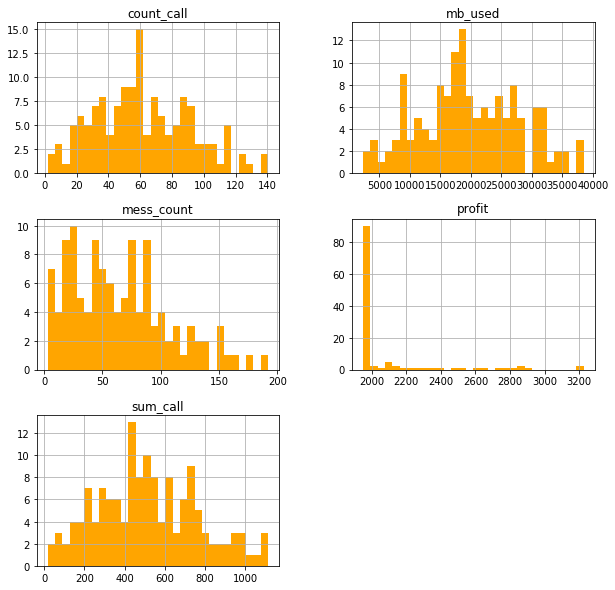

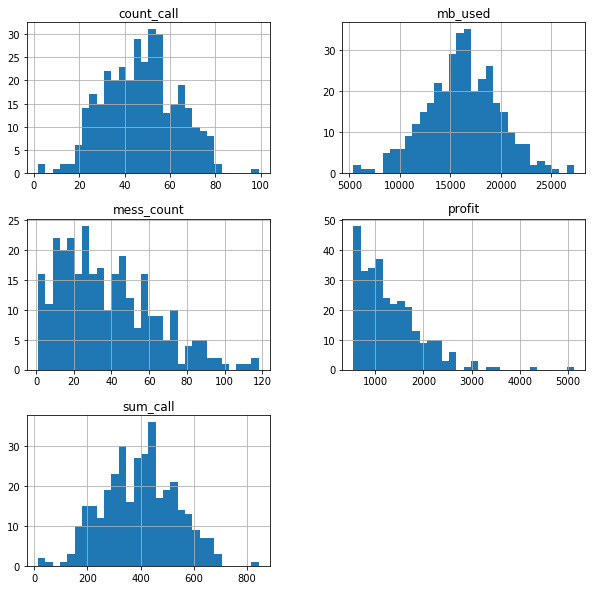

In [60]:
# поскольку значения потраченных минут, мегабайтов и число отправленных сообщений могут 
# носить только целые и строго определённые значения, то такие переменные будут - дискретными, 
# а значит к ним можно использовать обычную гистограмму частот
fd_ultra.hist(bins=30, figsize=(10,10), color='orange')
fd_smart.hist(bins=30, figsize=(10,10))

Исходя из построенных графиков для пользователей ultra и smart можно выделить следующие выводы:
- пользователи тарифа ultra совершаю больше кол-ва звонков, больше объем интернета, отправляю больше сообщений, суммарное кол-во потраченных минут также больше, чем у пользователей тарифа smart:
- из гистограммы следует, что пользователи тарифа smart приносят больше прибыли. Пародоксально. Это необходимо проверить путем выдвижения гипотез.

### Шаг 4. <a id="stat"></a> Проверка статистических гипотез

Для подготовки отчета заказчику необходимо проверить две гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

#### Проверка гипотезы, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [61]:
# создадим переменную, в которую сохраним информацию о пользователях тарифа ultra и прибыли, которую они приносят
fd_profit_ultra = (fd
                   .query('tariff_name == "ultra"')
                   .pivot_table(index='user_id', values='profit'))
fd_profit_ultra

# аналогично создадим переменную для прибыли от клиентов тарифа smart
fd_profit_smart = (fd
                   .query('tariff_name == "smart"')
                   .pivot_table(index='user_id', values='profit'))
fd_profit_smart.head()

,profit
user_id,
1002,1035.71
1005,753.75
1007,874.11
1008,568.00
1009,1310.00


In [62]:
# выдвигаем нулевую гипотезу H₀ - средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.
# H₀ всегда формулируется так, чтобы использовать знак равенства. 
# Другими словами, чтобы все значения, полученные эмпирически, не были экстремальными, а лежали там, где ожидаем их найти. 
# Альтернативная гипотеза - H₁ - средняя выручка пользователей тарифов «Ультра» и «Смарт» не одинакова.

# критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
alpha = .05

results = st.ttest_ind(fd_profit_ultra, fd_profit_smart)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается")
else:
    print("Не получилось отвергнуть нулевую гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается")

p-значение: [3.07029106e-29]
Отвергаем нулевую гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается


### Вывод 

В результате проверки гипотезы о равенстве средних двух генеральных совокупностей - пользователей тарифов ultra и smart, было выявлено, что p-значение: 3.07029106e-29 - это крайне малое значение - менее 0,001%, следовательно, есть основания отклонить нулевую гипотезу (а не автоматически отклонить), в таком случае выручка пользователей тарифов «Ультра» и «Смарт» различается: ответ на вопрос в большую или меньшую сторону такие методы не дают.

#### Проверка гипотезы, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [63]:
# создадим переменную, в которую сохраним информацию о пользователях из Москвы и прибыли, которую они приносят
fd_moscow = (fd
                   .query('city == "Москва"')
                   .pivot_table(index='user_id', values='profit'))
fd_moscow

# аналогично создадим переменную для прибыли от клиентов иных городов
fd_other = (fd
                   .query('city != "Москва"')
                   .pivot_table(index='user_id', values='profit'))
fd_other.head(10)

,profit
user_id,
1000,1950.00
1002,1035.71
1004,1950.00
1005,753.75
1008,568.00
1009,1310.00
1011,1500.60
1012,1810.00
1013,1950.00


In [64]:
# выдвигаем нулевую гипотезу H₀ - средняя выручка пользователей из Москвы равна выручке от пользователей из других регионов
# H₀ всегда формулируется так, чтобы использовать знак равенства. 
# Другими словами, чтобы все значения, полученные эмпирически, не были экстремальными, а лежали там, где ожидаем их найти. 
# Альтернативная гипотеза - H₁ - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

# критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
alpha = .05

results = st.ttest_ind(fd_moscow, fd_other)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу: средняя выручка пользователей из Москвы равна средней выручке от пользователей из других регионов")
else:
    print("Не получилось отвергнуть нулевую гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов")

p-значение: [0.74584401]
Не получилось отвергнуть нулевую гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов


### Вывод 

В результате проверки гипотезы о равенстве средних двух генеральных совокупностей - пользователей из Москвы и регионов, было выявлено, что p-значение: 0.74584401.
Полученное значение p-value говорит о том, что хотя средняя выручка пользователей в Москве и регионах неодинакова, с вероятностью в почти 75% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между выручкой в Москве и регионах.

### Шаг 5. <a id="Conclusion"></a> Общий вывод

Заказчиком - компанией «Мегалайн» — федеральным оператором сотовой связи, для корректировки рекламного бюджета, была поставлена задача - определить какой тариф приносит больше денег. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». 
- Тариф «Смарт»
1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.)
•	сообщение: 3 рубля
•	1 Гб интернет-трафика: 200 рублей

- Тариф «Ультра»
1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
•	минута разговора: 1 рубль
•	сообщение: 1 рубль
•	1 Гб интернет-трафика: 150 рублей

Для анализа была предоставлена выборка по 500 клиентам, пользовавшимися услугами оператора в 2018 году. Открыв файлы: /datasets/calls.csv, /datasets/internet.csv, /datasets/messages.csv, /datasets/tariffs.csv, /datasets/users.csv - была получена информация о пользователях, тарифах, совершенных звонках, отправленных сообщениях, потраченном объеме интернет-трафика.

После предварительного анализа были обнаружены недостатки, которые были устранены, а также для каждого пользователя было подсчитано:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя.

После предварительной подготовки данных была создана сводная таблица, включающая в себя основную информацию о кол-ва звонков, потраченного объема интернет-трафика, отправленных сообщениях, общем объеме потраченных на звонки минут. Также был создан столбец profit, включающий в себя информации о суммарной прибыли каждого клиента.

Создана сводная таблица об общем потреблении и о среднем потреблении той или иной категории услуг в зависимости от тарифа в разрезе месяцев 2018 г.

Исходя из представленной в переменной информации следует, что в среднем пользователи тарифа «Ультра» больше пользуются всеми услугами, входящими в такой пакет связи, даже с учетом того, что в суммарном количестве, пользователи тарифа «Смарт» потребляют больше. Видимо число пользователей тарифа «Смарт» больше, что при расчете среднего арифметического оказывает значительное влияния.

Рассчитана дисперсия и стандартное отклонение для пользователей тарифа «Ультра» и «Смарт».
Также были построены гистограммы для пользователей тарифов «Ультра» и «Смарт», по которым сделаны выводы:
- пользователи тарифа «Ультра» совершаю больше кол-ва звонков, больше объем интернета, отправляю больше сообщений, суммарное кол-во потраченных минут также больше, чем у пользователей тарифа «Смарт»:
- из гистограммы следует, что пользователи тарифа «Смарт» приносят больше прибыли. 
#### Проверка гипотез

Для проверки гипотезы, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, была выдвинута нулевая гипотеза H₀ - средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.
H₀ всегда формулируется так, чтобы использовать знак равенства. Другими словами, чтобы все значения, полученные эмпирически, не были экстремальными, а лежали там, где ожидаем их найти. 
Альтернативная гипотеа - H₁ - средняя выручка пользователей тарифов «Ультра» и «Смарт» не одинакова.

В результате проверки гипотезы о равенстве средних двух генеральных совокупностей - пользователей тарифов «Ультра» и «Смарт», было выявлено, что p-значение: 3.07029106e-29 - это крайне малое значение - менее 0,001%, следовательно, есть основания отклонить нулевую гипотезу (а не автоматически отклонить), в таком случае выручка пользователей тарифов «Ультра» и «Смарт» различается: ответ на вопрос в большую или меньшую сторону такие методы не дают.

Для проверки гипотезы, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов была выдвинута нулевая гипотеза H₀ - средняя выручка пользователей из Москвы равна выручке от пользователей из других регионов. Альтернативная гипотеза - H₁ - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
В результате проверки гипотезы о равенстве средних двух генеральных совокупностей - пользователей из Москвы и регионов, было выявлено, что p-значение: 0.74584401.

Полученное значение p-value говорит о том, что, хотя средняя выручка пользователей в Москве и регионах неодинакова, с вероятностью в почти 75% такое различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между выручкой в Москве и регионах.

Следовательно, поскольку пользователи тарифа «Смарт», согласно исследованию, приносят больше выручки (с учетом большего количества пользователей и доступности такого тарифа), и при этом согласно проверки гипотез выявлено, что среднее значение выручки тарифов «Смарт» и «Ультра» отличается, с учетом имеющейся информации целесообразнее вкладывать рекламный бюджет в развитие тарифа «Смарт».
